In [18]:
from torch.utils.data import Dataset
import pyedflib
import numpy as np
from scipy.signal import spectrogram, welch
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from chb_utils import parse_summary_file, parse_summary_file_chb24
import os
import random

In [39]:
class DataWindow:
    def __init__(self, record_id, record_file, start_index, end_index, label, channels):
        self.record_id = record_id
        self.record_file = record_file
        self.start_index = start_index
        self.end_index = end_index
        self.label = label
        self.channels = channels
        
    def get_data(self):
        with pyedflib.EdfReader(self.record_file) as f:
            labels = f.getSignalLabels()
            
            expected_channels = 23
            actual_channels   = f.signals_in_file
            
            data = []
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            #if len(idxs) != expected_channels: 
            #    raise ValueError(f'{len(idxs)} channels found, expected {expected_channels}.')
            
            size = self.end_index - self.start_index
            data = np.zeros((expected_channels, size))
            for i,j in enumerate(idxs):
                data[i, :] = f.readSignal(j, self.start_index, size)
        return data

In [40]:
class ChbDataset(Dataset):
    def __init__(self, data_dir='./chb-mit-scalp-eeg-database-1.0.0/',
                 seizures_only=True,sample_rate=256,subject='chb01',mode='train',
                 window_length=5, preictal_length=300, sampler='all', welch_features=False,
                 multiclass=True): 
        ### other sampler option is "equal"
        'Initialization'
        self.sample_rate = sample_rate
        self.subject = subject
        self.data_dir = data_dir
        self.window_length = window_length
        self.preictal_length = preictal_length
        self.welch_features = welch_features
        self.multiclass = multiclass
        self.sampler = sampler
        self.mode = mode
        self.record_type = 'RECORDS-WITH-SEIZURES' if seizures_only else 'RECORDS'
        self.records = None
        self.num_channels = 23
        self.preictal = []
        self.ictal = []
        self.interictal = []
        self.windows = []
        self.channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                               'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                               'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
        random.seed(1000)
        self.get_records() 
        self.get_labeled_windows()
        self.get_windows_for_epoch()
        
    def get_records(self):
        with open(self.data_dir+self.record_type) as f:
            self.records = f.read().strip().splitlines()
            f.close()
            
        with open(self.data_dir+'RECORDS-WITH-SEIZURES') as f:
            self.labelled = f.read().strip().splitlines()
            f.close()
            
        #filter based on subject
        self.records = [record for record in self.records if self.subject in record]
        
        if self.mode == 'train':
            limit_file = 'TRAIN_RECORDS.txt'
        else:
            limit_file = 'TEST_RECORDS.txt'
        with open(limit_file) as f:
            limit_records = set(f.read().strip().splitlines())
            records = set(self.records)
        self.records = list(records.intersection(limit_records))
        
        for record in self.records:
            f = pyedflib.EdfReader(self.data_dir+ '/'+record)
            labels = f.getSignalLabels()
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            if len(idxs) != len(self.channels):
                self.records.remove(record)
                print(f"Record {record} removed because it contained {len(idxs)} channels.")
            f.close()
        print(self.records)
    
    def get_labeled_windows(self):
        summary_file = os.path.join(
            self.data_dir,
            self.subject,
            f"{self.subject}-summary.txt")
        if self.subject == 'chb24':
            all_records = parse_summary_file_chb24(summary_file)
        else:
            all_records = parse_summary_file(summary_file)

        for record in all_records:
            #assert len(record.channels) == num_channels, f"Expected {num_channels} channels, found {len(record.channels)}"
            if f"{self.subject}/{record.fileid}" in self.records:
                filename = os.path.join(self.data_dir, self.subject, record.fileid)
                prev_end = 0
                    
                if record.duration is None:
                    duration = self.get_record_duration(filename)
                else:
                    duration = int(record.duration.total_seconds())
                end_of_file = duration * self.sample_rate
                if len(record.seizures) > 0:
                    seizures = []
                    for seizure in record.seizures:
                        if self.multiclass:
                            preictal_start = max(self.sample_rate * (seizure.start_time - self.preictal_length), 0)
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, preictal_start, 0,self.channels))
                            self.preictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename,preictal_start, ictal_start, 1,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 2,self.channels))
                            prev_end = ictal_end
                        else:
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, ictal_start, 0,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 1,self.channels))
                            prev_end = ictal_end
                self.interictal.extend(self.create_windows_for_segment(
                            record.fileid, filename, prev_end, end_of_file, 0,self.channels))
        #self.num_channels = num_channels
                
    def get_record_duration(self, recordfile):
        with pyedflib.EdfReader(recordfile) as f:
            duration = f.file_duration
        return duration
        
    def create_windows_for_segment(self, recordid, recordfile, start_index, end_index, label,channels):
        windows = []
        window_size = self.window_length * self.sample_rate
        for i in range(start_index, end_index - window_size + 1, window_size):
            windows.append(DataWindow(recordid, recordfile, i, i + window_size, label,channels))
        return windows
                
    def get_windows_for_epoch(self):
        #print(self.sampler)
        if self.sampler == 'all':
            self.windows = self.interictal + self.preictal + self.ictal
        elif self.sampler == 'equal' and self.multiclass:
            num_samples = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.preictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
            #print(len(self.windows))
        elif self.sampler == 'equal' and not self.multiclass:
            num_samples = min([len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
        else:
            raise ValueError("Sampler must be all or equal")
            
    def __len__(self):
        'Denotes the total number of samples'
        if self.sampler == 'all':
            return len(self.preictal) + len(self.interictal) + len(self.ictal)
        elif self.sampler == 'equal' and self.multiclass:
            smallest = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            return smallest * 3
        elif self.sampler == 'equal' and not self.multiclass:
            smallest = min([len(self.interictal), len(self.ictal)])
            return smallest * 2
        else:
            raise ValueError("Sampler must be all or equal")
        
    def __getitem__(self, index):
        'Generates one sample of data, which is one window of length window_length'
        # Select sample
        window = self.windows[index]
        data = window.get_data()
        label = window.label
        if self.welch_features:
            sample = self.__welch_features(data)
            data = sample.flatten()
        return data, label
    
    def all_data(self):
        data = [self.__getitem__(i) for i in range(len(self))]
        #print(data[0])
        allY = np.concatenate([[x[1] for x in data]])
        allX = np.array([x[0] for x in data])
        return allX,allY
    
    def __welch_features(self, sample):
        p_f, p_Sxx = welch(sample, fs=self.sample_rate, axis=1)
        p_SS = np.log1p(p_Sxx)
        arr = p_SS[:] / np.max(p_SS)
        return arr

In [51]:
class XGBoostTrainer:
    def __init__(self):
        self.model = XGBClassifier(objective='binary:hinge', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
        self.subjects = ['chb0'+str(i) for i in range(1,10)] + ['chb' + str(i) for i in range(10,25)]
        self.preds = []
        self.labels = []
        
    def train_all(self):
        
        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject, welch_features=True, sampler='equal', multiclass=True)
            tests = ChbDataset(mode='test' ,subject=subject, welch_features=True, sampler='equal', multiclass=True)
        
            allX,allY = train.all_data()
            
            self.model.fit(allX, allY)
            
            testX,testY = tests.all_data()

            preds = self.model.predict(testX)
            self.preds.append((preds))
            self.labels.append(testY)
                
            print(sum(preds==testY)/len(testY))

In [52]:
run = True
if run:
    m = XGBoostTrainer()
    m.train_all()

Training chb01
['chb01/chb01_03.edf', 'chb01/chb01_26.edf', 'chb01/chb01_21.edf', 'chb01/chb01_16.edf', 'chb01/chb01_15.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files
['chb01/chb01_04.edf', 'chb01/chb01_18.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5942028985507246
Training chb02
['chb02/chb02_16+.edf', 'chb02/chb02_16.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 36 edf files
['chb02/chb02_19.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 36 edf files
[11:26:12] WARNING: C:

[11:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6111111111111112
Training chb10
['chb10/chb10_31.edf', 'chb10/chb10_89.edf', 'chb10/chb10_12.edf', 'chb10/chb10_27.edf', 'chb10/chb10_30.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 25 edf files
['chb10/chb10_38.edf', 'chb10/chb10_20.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9

C:\Users\Filip\AppData\Local\Temp/ipykernel_16612/1431634685.py:176: RuntimeWarning: invalid value encountered in true_divide
  arr = p_SS[:] / np.max(p_SS)


[11:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7536231884057971
Training chb13
['chb13/chb13_59.edf', 'chb13/chb13_58.edf', 'chb13/chb13_62.edf', 'chb13/chb13_19.edf', 'chb13/chb13_21.edf', 'chb13/chb13_55.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'LUE-RAE', 'EKG1-EKG2', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 

0.4444444444444444
Training chb17
['chb17/chb17a_04.edf', 'chb17/chb17a_03.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2']
found 50 channels
found 21 edf files
['chb17/chb17b_63.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4

0.6923076923076923
Training chb24
['chb24/chb24_07.edf', 'chb24/chb24_14.edf', 'chb24/chb24_04.edf', 'chb24/chb24_17.edf', 'chb24/chb24_21.edf', 'chb24/chb24_09.edf', 'chb24/chb24_11.edf', 'chb24/chb24_13.edf', 'chb24/chb24_03.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 12 edf files
['chb24/chb24_15.edf', 'chb24/chb24_06.edf', 'chb24/chb24_01.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 12 edf files
[11:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the def

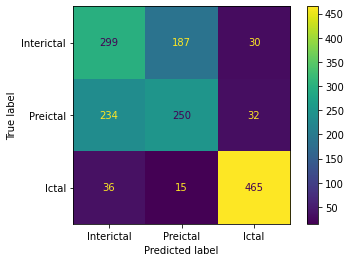

In [65]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay,roc_auc_score, f1_score,classification_report
#import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
if run:
    y_true = np.concatenate(m.labels)
    y_pred_class = np.concatenate(m.preds)

    y_pred_null = np.zeros_like(y_pred_class)

    cm = confusion_matrix(y_true, y_pred_class)
    cm2 = confusion_matrix(y_true, y_pred_null)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    #tn, fp, fn, tp = cm.ravel()

    cm_display = ConfusionMatrixDisplay(cm,display_labels=['Interictal','Preictal','Ictal']).plot()
    #cm_display2 = ConfusionMatrixDisplay(cm2).plot()

0.9183168316831684 0.5
False positives per day: [93.45592212 69.91887507 21.46024878]


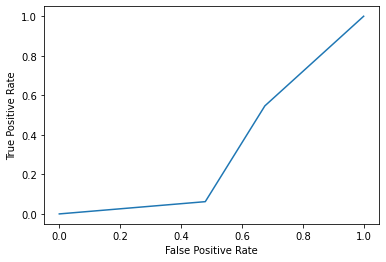

In [66]:
if run:
    fpr, tpr, _ = roc_curve(y_true, y_pred_class,pos_label=1)#, pos_label=m.model.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    #r = roc_auc_score(y_true,y_pred_class)
    #r2 = roc_auc_score(y_true,y_pred_null)
    print(r,r2)
    print("False positives per day: " + str(FPR/((FP+TN)/256/60)*24))

In [55]:
if run: 
    print(classification_report(y_true,y_pred_class))
    print(classification_report(y_true,y_pred_null))

              precision    recall  f1-score   support

           0       0.53      0.58      0.55       516
           1       0.55      0.48      0.52       516
           2       0.88      0.90      0.89       516

    accuracy                           0.66      1548
   macro avg       0.65      0.66      0.65      1548
weighted avg       0.65      0.66      0.65      1548

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       516
           1       0.00      0.00      0.00       516
           2       0.00      0.00      0.00       516

    accuracy                           0.33      1548
   macro avg       0.11      0.33      0.17      1548
weighted avg       0.11      0.33      0.17      1548



c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
FP

array([270, 202,  62], dtype=int64)